In [2]:
# prompt: mount to drive, cd to summer 2024/group project

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd /content/drive/MyDrive/summer2024/group\ project

## Load and Review Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# data = pd.read_csv('cleaned_data.csv')
data = pd.read_csv('sandiego_listings.csv')
data.head()
print(data.columns)

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license'],
      dtype='object')


In [38]:
data = data.drop(columns=['neighbourhood_group', 'neighbourhood', 'license', 'name', 'id', 'name', 'host_id', 'host_name', 'last_review'])

In [39]:
data['room_type'].value_counts()

room_type
Entire home/apt    9846
Private room       1573
Shared room          68
Hotel room            9
Name: count, dtype: int64

In [40]:
room_type_dict = {'Entire home/apt':0, 'Private room':1, 'Shared room': 2, 'Hotel room':3}
data['room_type'] = data['room_type'].replace(room_type_dict)
data['room_type'].value_counts()

C:\Users\sangd\AppData\Local\Temp\ipykernel_12020\2477849265.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['room_type'] = data['room_type'].replace(room_type_dict)


room_type
0    9846
1    1573
2      68
3       9
Name: count, dtype: int64

In [41]:
data.describe().round(3)

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,11496.000,11496.000,11496.000,11230.000,11496.000,11496.000,9824.000,11496.000,11496.000,11496.000
mean,32.770,-117.185,0.151,301.299,11.159,65.289,1.949,14.126,204.360,16.025
std,0.064,0.066,0.380,461.832,20.261,105.390,1.991,25.893,112.309,22.571
min,32.541,-117.282,0.000,10.000,1.000,0.000,0.010,1.000,0.000,0.000
25%,32.729,-117.250,0.000,120.000,2.000,3.000,0.530,1.000,98.000,1.000
50%,32.762,-117.179,0.000,189.000,3.000,22.000,1.470,3.000,217.000,8.000
75%,32.798,-117.142,0.000,335.000,30.000,81.000,2.890,14.000,306.000,26.000
max,33.102,-116.937,3.000,10000.000,1000.000,1049.000,55.330,156.000,365.000,687.000


## Add income_group

### 1. calculate income

In [42]:
# create column income
data['income'] = data['price'] * data['reviews_per_month']

<Axes: >

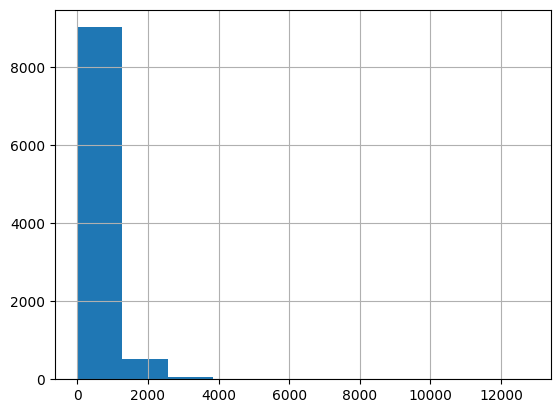

In [43]:
data['income'].hist()

### crop some outliners

Seem like the data is still very skewed, we're gonna crop some outliners

In [44]:
def remove_outliers_iqr(df, columns, th1=0.01, th3=0.90, multiplier=1.5):
    for column in columns:
        Q1 = df[column].quantile(th1)
        Q3 = df[column].quantile(th3)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        print(f"column: {column}, lower_bound: {lower_bound}, upper_bound: {upper_bound}")
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

data = remove_outliers_iqr(data, ['income'], th1=0.1, th3 = 0.80)

column: income, lower_bound: -978.3420000000002, upper_bound: 1718.8900000000003


count    9360.000000
mean      394.060899
std       363.680012
min         0.620000
25%       104.000000
50%       289.120000
75%       573.450000
max      1716.900000
Name: income, dtype: float64

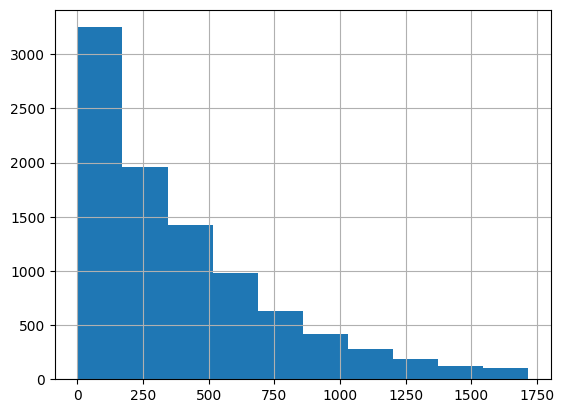

In [45]:
data['income'].hist()
data['income'].describe()

### income_group

It'd be good to divide the group based on the percentiles. This would allows the group proportion to be equal, and the values look quite reasonable

In [46]:
first_quartile = data['income'].quantile(0.25)
second_quartile = data['income'].quantile(0.5)
third_quartile = data['income'].quantile(0.75)
fourth_quartile = data['income'].quantile(1)

data['income_group'] = data['income'].apply(lambda x: 0 if x < first_quartile else 1 if x < second_quartile else 2 if x < third_quartile else 3)

# data['income_group'] = data['income'].apply(lambda x: 0 if x < 750 else 1 if x < 1500 else 2 if x < 2250 else 3)

data['income_group'].value_counts()



income_group
1    2343
2    2340
3    2340
0    2337
Name: count, dtype: int64

## Data Prep

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

In [59]:
new_data = data.drop(columns=['income', 'reviews_per_month','number_of_reviews','number_of_reviews_ltm'])

### Scaling

some features use StandardScaler, some use MinMaxscaler

In [60]:
# standardization
# standardized_cols = ['latitude', 'longitude']  # we use stardard scaler for these columns because there are negative values here

# standard_scaler = StandardScaler()

# new_data[standardized_cols] = standard_scaler.fit_transform(data[standardized_cols])

# minmax normalization
minmax_cols = ['room_type', 'price' ,'minimum_nights', 	'calculated_host_listings_count','availability_365','latitude', 'longitude', 'income_group']

min_max_scaler = MinMaxScaler()

new_data[minmax_cols] = min_max_scaler.fit_transform(data[minmax_cols])

In [61]:
new_data.describe()

,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,income_group
count,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000,9360.000000
mean,0.408026,0.278230,0.046546,0.026015,0.021992,0.084325,0.556635,0.500107
std,0.112644,0.192466,0.121552,0.034479,0.039853,0.168073,0.303255,0.372602
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.339496,0.090950,0.000000,0.010911,0.002747,0.000000,0.271233,0.333333
50%,0.393241,0.284953,0.000000,0.017317,0.002747,0.012903,0.582192,0.500000
75%,0.458870,0.407282,0.000000,0.030130,0.013736,0.077419,0.835616,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
# income_group and room_type are orginilly categorical, then discrete data, just want to check if they're still are
print(new_data['income_group'].value_counts())
print(new_data['room_type'].value_counts())

income_group
0.333333    2343
0.666667    2340
1.000000    2340
0.000000    2337
Name: count, dtype: int64
room_type
0.000000    8111
0.333333    1193
0.666667      54
1.000000       2
Name: count, dtype: int64


### Split data to train and test, one hot encode target

In [63]:
X = new_data.drop(columns=['income_group']).values
y = new_data['income_group'].values

#OHE
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) #
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

## Model

In [30]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import L2

### Hyperparameters

In [125]:
input_size = X_train.shape[1]
num_classes = y_train.shape[1]
batch_size = 100
epochs = 200
learning_rate = 0.001

### Model Init

In [136]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(input_size,))) #, kernel_regularizer=L2(0.01)
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu')) #,kernel_regularizer=L2(0.01)
# model.add(Dropout(0.1))
model.add(Dense(256, activation='relu')) #,kernel_regularizer=L2(0.01)
# model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 256)               2048      
                                                                 
 dense_73 (Dense)            (None, 256)               65792     
                                                                 
 dense_74 (Dense)            (None, 256)               65792     
                                                                 
 dense_75 (Dense)            (None, 256)               65792     
                                                                 
 dense_76 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 200,452
Trainable params: 200,452
Non-trainable params: 0
_________________________________________________________________


## Train

In [137]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=1, callbacks=[callback]) #

Epoch 1/200
75/75 [==============================] - 1s 4ms/step - loss: 1.2920 - accuracy: 0.3663 - val_loss: 1.1703 - val_accuracy: 0.4423
Epoch 2/200
75/75 [==============================] - 0s 2ms/step - loss: 1.1707 - accuracy: 0.4518 - val_loss: 1.1500 - val_accuracy: 0.4610
Epoch 3/200
75/75 [==============================] - 0s 2ms/step - loss: 1.1584 - accuracy: 0.4650 - val_loss: 1.1544 - val_accuracy: 0.4647
Epoch 4/200
75/75 [==============================] - 0s 3ms/step - loss: 1.1516 - accuracy: 0.4720 - val_loss: 1.1946 - val_accuracy: 0.4412
Epoch 5/200
75/75 [==============================] - 0s 2ms/step - loss: 1.1482 - accuracy: 0.4777 - val_loss: 1.1508 - val_accuracy: 0.4701
Epoch 6/200
75/75 [==============================] - 0s 2ms/step - loss: 1.1448 - accuracy: 0.4756 - val_loss: 1.1388 - val_accuracy: 0.4824
Epoch 7/200
75/75 [==============================] - 0s 2ms/step - loss: 1.1411 - accuracy: 0.4790 - val_loss: 1.1227 - val_accuracy: 0.4840
Epoch 8/200
7

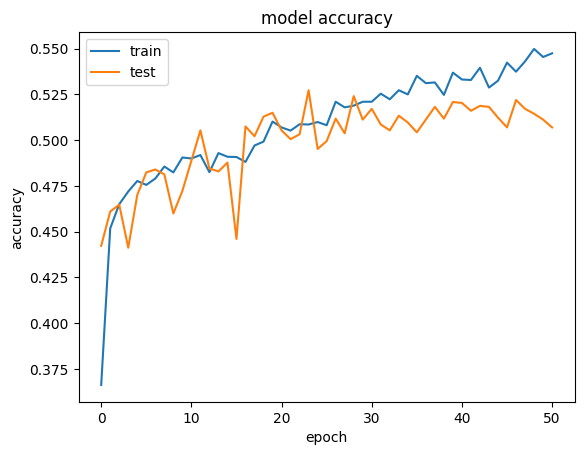

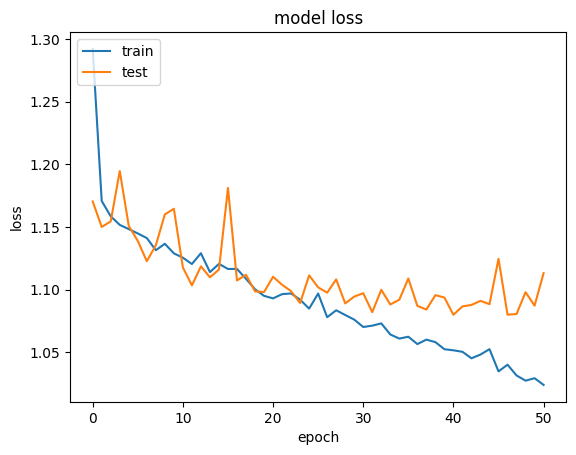

In [138]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [139]:
yhat_test = model.predict(X_test).round(3)
yhat_test_idx = np.argmax(yhat_test, axis=1)
y_labels = y_test
y_labels_idx = np.argmax(y_labels, axis=1)
# print(yhat_test*100)
# for i in zip(yhat_test_idx, y_labels_idx):
#     print(i)

59/59 [==============================] - 0s 708us/step


In [145]:
def predict(idx, r):
    yhat_test = model.predict(X_test[idx:idx+r]).round(3)
    yhat_test_idx = np.argmax(yhat_test, axis=1)
    y_labels = y_test[idx:idx+r]
    y_labels_idx = np.argmax(y_labels, axis=1)
    # print(yhat_test*100)
    for i in zip(yhat_test*100, yhat_test_idx, y_labels_idx):
        print(f"predict%: {i[0]} = {i[1]} | actual: {i[2]}")
predict(565, 5)

1/1 [==============================] - 0s 18ms/step
predict%: [ 3.1      33.8      59.100002  4.      ] = 2 | actual: 1
predict%: [ 3.3      31.900002 35.7      29.199999] = 2 | actual: 1
predict%: [11.8      54.8      28.600002  4.8     ] = 1 | actual: 1
predict%: [16.2      23.199999 47.1      13.500001] = 2 | actual: 2
predict%: [ 0.9  3.5 20.4 75.3] = 3 | actual: 3


<Axes: >

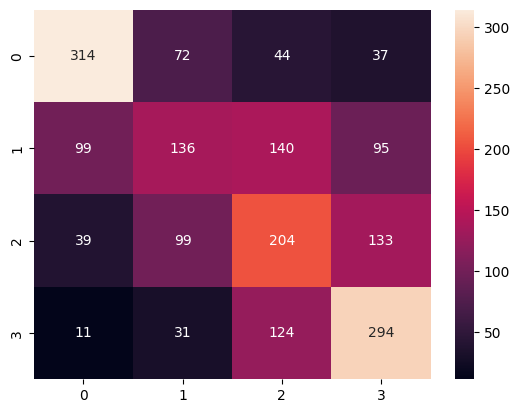

In [109]:
cm = confusion_matrix(y_labels_idx, yhat_test_idx)
sns.heatmap(cm, annot=True, fmt='d')

In [111]:
print(classification_report(y_labels_idx, yhat_test_idx))

              precision    recall  f1-score   support

           0       0.68      0.67      0.68       467
           1       0.40      0.29      0.34       470
           2       0.40      0.43      0.41       475
           3       0.53      0.64      0.58       460

    accuracy                           0.51      1872
   macro avg       0.50      0.51      0.50      1872
weighted avg       0.50      0.51      0.50      1872



## Save Model

In [27]:
model.save('c_model.keras')

In [28]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


## Cross-validation (probably not necessary, since our accuracy is pretty high)

# Suggesting Model

### TODO:
  1. Write script that asks for user input
  2. redo StardardScaler and MinMaxScaler, we need to record the meand and std of each column, so we can stardardize and normalize user input manually
  3. Feed user input to Price Predicting model, get price range
  4. For each price, feed user input + price to this classification model
  5. Report the likelyhood of monthly income, suggest ideal price of the listing